# Testing for an non homogeneous Hamiltonian

In [57]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import shutil
import os
import time
import cv2
import csv
from PIL import Image
from numba import jit
import pickle
from pathlib import Path
import skimage.measure

from keras.models import load_model
from sklearn import metrics

In [58]:
# check the nth ('n') of an integer 'num'
def check_nth_bit(num, n):
    return (num>>n)&1

# flip the bit of the integer 'int' at a position 'p'  (staring at 0)
def bitflip(int,p):
    mask = 1 << p
    return (int^ mask)

# count the numbers of 1 on a binarie representetion of an interger n
def CountBits(n):
    n = (n & 0x5555555555555555) + ((n & 0xAAAAAAAAAAAAAAAA) >> 1)
    n = (n & 0x3333333333333333) + ((n & 0xCCCCCCCCCCCCCCCC) >> 2)
    n = (n & 0x0F0F0F0F0F0F0F0F) + ((n & 0xF0F0F0F0F0F0F0F0) >> 4)
    n = (n & 0x00FF00FF00FF00FF) + ((n & 0xFF00FF00FF00FF00) >> 8)
    n = (n & 0x0000FFFF0000FFFF) + ((n & 0xFFFF0000FFFF0000) >> 16)
    n = (n & 0x00000000FFFFFFFF) + ((n & 0xFFFFFFFF00000000) >> 32) 
    return n

# defining n!
@jit
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

# finding the states that have the maginetization "z"
@jit
def statep(y,z):
    a = 0
    for x in range(0,2**l):
        if (2* CountBits(x)-l) == z:
            y[a] = x
            a += 1
    return (y)

# numbers of states with magnatization x
def num_mag(x):
    y = p = int(factorial(l)//((factorial((x+l)/2))*(factorial(l -((x+l)/2)))))
    return y
            
# find the position in the list of states "s" that are iqual to "b"
@jit
def find_state(s,b):
    for z in range(0,p+1):
        if s[z] == b:
            return(z)

# power method
@jit
def power_iteration(A):
    # Choose a random vector
    y_0 = np.random.rand(A.shape[0])
    #erro precision
    e= 0.000000001
    #convergence constant
    er= 1.0
    it = 0
    while (er >= e):
        # calculate the matrix-by-vector product Ab
        z_1 = np.dot(A, y_0)
        # calculate the norm
        z_1_norm = np.linalg.norm(z_1)
        # renormalize the vector
        y_1 = z_1 / z_1_norm
        z_2 = np.dot(A, y_1)
        z_2_norm = np.linalg.norm(z_2)
        lamb_1 = np.dot(z_2,y_1)/np.dot(y_1,y_1)
        y_2 = z_2/z_2_norm
        z_3 = np.dot(A, y_2)
        z_3_norm = np.linalg.norm(z_3)
        lamb_2 = np.dot(z_3,y_2)/np.dot(y_2,y_2)
        er = abs(lamb_1 - lamb_2)/abs(lamb_2)
        y_0 = z_3/z_3_norm
        it += 1
        #if( it%10 == 0):print('# of interations:',it,';','Precision:', er)
    return (y_0, lamb_2)

@jit
def POWER_METHOD(A,dim):
    for x in range(0,dim):
        A[x,x] -= 2*l
        
    C = np.asarray(power_iteration(A))
    C[1] += 2*l
    return (C)

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.title('RMSE ='+ str(np.round(100000*score)/100000))
    plt.savefig('predct.png')

## Single site external magnect field

8/8 [==============================] - 1s 164ms/step
Score (RMSE): 0.2992966647096677


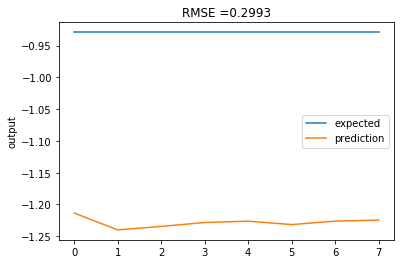

In [40]:
# number of spins
l = 8

#dimension constant
j = 1

#anisotropy constant
delt = -1

path_folder = 'matrix_del/'
ex = '.npy'

if not os.path.exists(path_folder):
    os.mkdir(path_folder)

c_i = 1
h = np.zeros(l)
row = []
for i in range(0,8):
    
    h[i] = c_i
    
    Hxxz = np.zeros((2**l , 2**l ))

    # constructing the full xxz hamiltonian (2^L, 2^L) 
    for x in range(0,2**l):
        for y in range(0,l):
            k = (y+1)%l
            if check_nth_bit(x,y) == 0:
                Hxxz[x,x] += -j*h[y]/2
            else:
                Hxxz[x,x] += j*h[y]/2
            #if y != l-1:    
            if check_nth_bit(x,y) == check_nth_bit(x,k):
                Hxxz[x,x] += -(j*delt)/2
            else:
                Hxxz[x,x] += (j*delt)/2
                b = bitflip(x,y)
                c = bitflip(b,k)
                Hxxz[x,c] += -j
    #print(Hxxz)
       
    
    mag_array = np.zeros(l+1)
    E_array = np.zeros(l+1)
    a = 0
    for mag in range(-l,l+1,2):
    
        p = num_mag(mag)
        state = np.array(range(p))
        s = statep(state,mag)
        
        Hxxz_p = np.zeros((p,p))
        for x in range(0,p):
            for y in range(0,l):
                if check_nth_bit(s[x],y) == 0:
                    Hxxz_p[x,x] += -(j*h[y])/2
                else:
                    Hxxz_p[x,x] += (j*h[y])/2
                k = (y+1)%l
                #if y != l-1:
                if check_nth_bit(s[x],y) == check_nth_bit(s[x],k):
                    Hxxz_p[x,x] += -(j*delt)/2
                else:
                    Hxxz_p[x,x] += (j*delt)/2
                    b = bitflip(s[x],y)
                    c = bitflip(b,k)
                    D = np.where(s == c)
                    Hxxz_p[x,D] = -j
                                            
        #print(Hxxz_p)
        mag_array[a] = mag
        A = POWER_METHOD(Hxxz_p,p)
        E_array[a] = A[1] 
        psi_s = -mag_array[np.where(E_array == np.min(E_array))]
        a += 1
   
    row.append([str(i+1) + ex, np.min(E_array)/l])
    np.save(os.path.abspath(path_folder+str(i+1)), Hxxz)   
    #print('h:',h)
    #print('MAG_GS:', psi_s[0])
    #print('rhoE_array:', np.min(E_array)/l)
    
    h[i] = 0
row = np.asarray(row)

x_test = row[:,0]
y_test = np.array(row[:,1]).astype(np.float)

test_data = []

load_test_data = []
for file in x_test:
        path = os.path.abspath(path_folder + file)
        H = np.load(path)
        load_test_data.append(H)
load_test_data = np.array(load_test_data)
test_data = load_test_data[:,:,:,np.newaxis]
test_data -= np.mean(test_data)
test_data /= np.std(test_data)

test_label = []
for file in y_test:
    test_label.append(file)
test_label = np.array(test_label)

model = load_model('my_model.h5')

pred = model.predict(test_data, verbose=1)
score = np.sqrt(metrics.mean_squared_error(pred,test_label))
print("Score (RMSE): {}".format(score))

chart_regression(pred.flatten(),test_label)

## Random local magnect field

100/100 [==============================] - 12s 116ms/step
Score (RMSE): 0.252753747276247


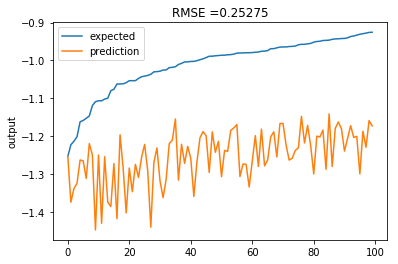

In [49]:
path_folder = 'matrix_del_rand/'
ex = '.npy'

if not os.path.exists(path_folder):
    os.mkdir(path_folder)

c_i = 0.5

row = []
for i in range(0,100):
    
    h = np.random.randn(l)
    
    Hxxz = np.zeros((2**l , 2**l ))

    # constructing the full xxz hamiltonian (2^L, 2^L) 
    for x in range(0,2**l):
        for y in range(0,l):
            k = (y+1)%l
            if check_nth_bit(x,y) == 0:
                Hxxz[x,x] += -j*h[y]/2
            else:
                Hxxz[x,x] += j*h[y]/2
            #if y != l-1:    
            if check_nth_bit(x,y) == check_nth_bit(x,k):
                Hxxz[x,x] += -(j*delt)/2
            else:
                Hxxz[x,x] += (j*delt)/2
                b = bitflip(x,y)
                c = bitflip(b,k)
                Hxxz[x,c] += -j
    #print(Hxxz)
       
    
    mag_array = np.zeros(l+1)
    E_array = np.zeros(l+1)
    a = 0
    for mag in range(-l,l+1,2):
    
        p = num_mag(mag)
        state = np.array(range(p))
        s = statep(state,mag)
        
        Hxxz_p = np.zeros((p,p))
        for x in range(0,p):
            for y in range(0,l):
                if check_nth_bit(s[x],y) == 0:
                    Hxxz_p[x,x] += -(j*h[y])/2
                else:
                    Hxxz_p[x,x] += (j*h[y])/2
                k = (y+1)%l
                #if y != l-1:
                if check_nth_bit(s[x],y) == check_nth_bit(s[x],k):
                    Hxxz_p[x,x] += -(j*delt)/2
                else:
                    Hxxz_p[x,x] += (j*delt)/2
                    b = bitflip(s[x],y)
                    c = bitflip(b,k)
                    D = np.where(s == c)
                    Hxxz_p[x,D] = -j
                                            
        #print(Hxxz_p)
        mag_array[a] = mag
        A = POWER_METHOD(Hxxz_p,p)
        E_array[a] = A[1] 
        psi_s = -mag_array[np.where(E_array == np.min(E_array))]
        a += 1
   
    row.append([str(i+1) + ex, np.min(E_array)/l])
    np.save(os.path.abspath(path_folder+str(i+1)), Hxxz)   
    #print('h:',h)
    #print('MAG_GS:', psi_s[0])
    #print('rhoE_array:', np.min(E_array)/l)
    
    
row = np.asarray(row)

x_test = row[:,0]
y_test = np.array(row[:,1]).astype(np.float)

test_data = []

load_test_data = []
for file in x_test:
        path = os.path.abspath(path_folder + file)
        H = np.load(path)
        load_test_data.append(H)
load_test_data = np.array(load_test_data)
test_data = load_test_data[:,:,:,np.newaxis]
test_data -= np.mean(test_data)
test_data /= np.std(test_data)

test_label = []
for file in y_test:
    test_label.append(file)
test_label = np.array(test_label)

model = load_model('my_model.h5')

pred = model.predict(test_data, verbose=1)
score = np.sqrt(metrics.mean_squared_error(pred,test_label))
print("Score (RMSE): {}".format(score))

chart_regression(pred.flatten(),test_label)

## Pooling the dimensions 

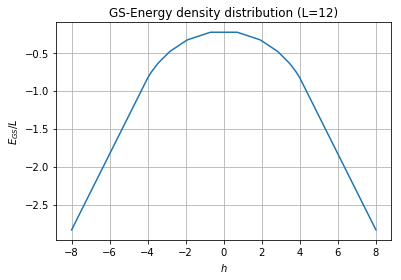

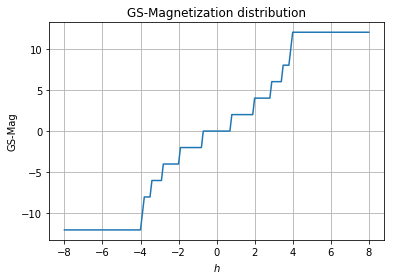

161/161 [==============================] - 19s 116ms/step
Score (RMSE): 0.6090384055469993


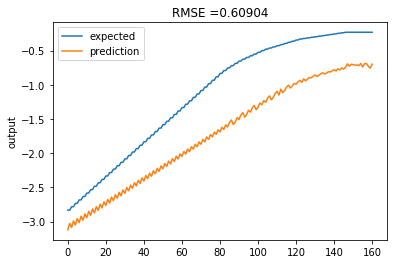

In [56]:
# number of spins
l = 12

#dimension constant
j = 1

#anisotropy constant
delt = -1

path_folder = 'matrix_pool/'

if not os.path.exists(path_folder):
    os.mkdir(path_folder)
    
h = -8.
row = []
while h <= 8:
    
    Hxxz = np.zeros((2**l , 2**l ))

    # constructing the full xxz hamiltonian (2^L, 2^L) 
    for x in range(0,2**l):
        for y in range(0,l):
            k = (y+1)%l
            if check_nth_bit(x,y) == 0:
                Hxxz[x,x] += -j*h/2
            else:
                Hxxz[x,x] += j*h/2
            #if y != l-1:    
            if check_nth_bit(x,y) == check_nth_bit(x,k):
                Hxxz[x,x] += -(j*delt)/2
            else:
                Hxxz[x,x] += (j*delt)/2
                b = bitflip(x,y)
                c = bitflip(b,k)
                Hxxz[x,c] += -j

    
    
    mag_array = np.zeros(l+1)
    E_array = np.zeros(l+1)
    a = 0
    for mag in range(-l,l+1,2):
    
        p = num_mag(mag)
        state = np.array(range(p))
        s = statep(state,mag)
        
        Hxxz_p = np.zeros((p,p))
        for x in range(0,p):
            for y in range(0,l):
                if check_nth_bit(s[x],y) == 0:
                    Hxxz_p[x,x] += -(j*h)/2
                else:
                    Hxxz_p[x,x] += (j*h)/2
                k = (y+1)%l
                #if y != l-1:
                if check_nth_bit(s[x],y) == check_nth_bit(s[x],k):
                    Hxxz_p[x,x] += -(j*delt)/2
                else:
                    Hxxz_p[x,x] += (j*delt)/2
                    b = bitflip(s[x],y)
                    c = bitflip(b,k)
                    D = np.where(s == c)
                    Hxxz_p[x,D] = -j
                        #if mag == 0:
                            #print('[',x,D,']','k:',k,'s[x]:',s[x],'y:',y,'b:',b,'c:',c,'s[5]',s[5])
                    
        #print(Hxxz_p)
        mag_array[a] = mag
        A = POWER_METHOD(Hxxz_p,p)
        E_array[a] = A[1] 
        psi_s = -mag_array[np.where(E_array == np.min(E_array))]
        a += 1
    ex = '.npy'
    Hxxz_pool = skimage.measure.block_reduce(Hxxz,(16,16), np.average)
    np.save(os.path.abspath(path_folder + str(h)), Hxxz_pool)
    row.append([str(h) + ex, psi_s[0], np.min(E_array)/l, h])
            
        
    #print('h:',h)
    #print('MAG_GS:', psi_s[0])
    #print('rhoE_array:', np.min(E_array)/l)
    h += .1
    
row = np.asarray(row)

a_h = np.array(row[:,3]).astype(np.float) #h
b_e = np.array(row[:,2]).astype(np.float) #E_GS/l
c_m = np.array(row[:,1]).astype(np.float) #mag_GS

plt.plot(a_h,b_e,'-')
plt.title('GS-Energy density distribution (L='+str(l)+')')
plt.xlabel(r'$h$')
plt
plt.ylabel(r'$E_{GS}/L$')
plt.grid()
plt.savefig('GS-Energy_big.png')
plt.show()


plt.plot(a_h,c_m)
plt.title('GS-Magnetization distribution')
plt.xlabel(r'$h$')
plt.ylabel('GS-Mag')
plt.grid()
plt.savefig('GS-Mag_big.png')
plt.show()

x_test = row[:,0]
y_test = np.array(row[:,2]).astype(np.float)

test_data = []

load_test_data = []
for file in x_test:
        path = os.path.abspath(path_folder + file)
        H = np.load(path)
        load_test_data.append(H)
load_test_data = np.array(load_test_data)
test_data = load_test_data[:,:,:,np.newaxis]
test_data -= np.mean(test_data)
test_data /= np.std(test_data)

test_label = []
for file in y_test:
    test_label.append(file)
test_label = np.array(test_label)

model = load_model('my_model.h5')

pred = model.predict(test_data, verbose=1)
score = np.sqrt(metrics.mean_squared_error(pred,test_label))
print("Score (RMSE): {}".format(score))

chart_regression(pred.flatten(),test_label)

### Pooling and random local MF

100/100 [==============================] - 12s 119ms/step
Score (RMSE): 0.8795183218527095


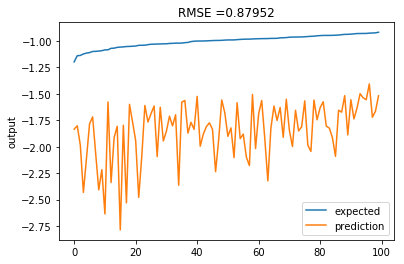

In [60]:
# number of spins
l = 12

#dimension constant
j = 1

#anisotropy constant
delt = -1

path_folder = 'matrix_pool/'

if not os.path.exists(path_folder):
    os.mkdir(path_folder)
    

row = []
for i in range(0,100):
    
    h = np.random.randn(l)
    Hxxz = np.zeros((2**l , 2**l ))

    # constructing the full xxz hamiltonian (2^L, 2^L) 
    for x in range(0,2**l):
        for y in range(0,l):
            k = (y+1)%l
            if check_nth_bit(x,y) == 0:
                Hxxz[x,x] += -j*h[y]/2
            else:
                Hxxz[x,x] += j*h[y]/2
            #if y != l-1:    
            if check_nth_bit(x,y) == check_nth_bit(x,k):
                Hxxz[x,x] += -(j*delt)/2
            else:
                Hxxz[x,x] += (j*delt)/2
                b = bitflip(x,y)
                c = bitflip(b,k)
                Hxxz[x,c] += -j

    
    
    mag_array = np.zeros(l+1)
    E_array = np.zeros(l+1)
    a = 0
    for mag in range(-l,l+1,2):
    
        p = num_mag(mag)
        state = np.array(range(p))
        s = statep(state,mag)
        
        Hxxz_p = np.zeros((p,p))
        for x in range(0,p):
            for y in range(0,l):
                if check_nth_bit(s[x],y) == 0:
                    Hxxz_p[x,x] += -(j*h[y])/2
                else:
                    Hxxz_p[x,x] += (j*h[y])/2
                k = (y+1)%l
                #if y != l-1:
                if check_nth_bit(s[x],y) == check_nth_bit(s[x],k):
                    Hxxz_p[x,x] += -(j*delt)/2
                else:
                    Hxxz_p[x,x] += (j*delt)/2
                    b = bitflip(s[x],y)
                    c = bitflip(b,k)
                    D = np.where(s == c)
                    Hxxz_p[x,D] = -j
                        
                    
        #print(Hxxz_p)
        mag_array[a] = mag
        A = POWER_METHOD(Hxxz_p,p)
        E_array[a] = A[1] 
        psi_s = -mag_array[np.where(E_array == np.min(E_array))]
        a += 1
    ex = '.npy'
    Hxxz_pool = skimage.measure.block_reduce(Hxxz,(16,16), np.max)
    np.save(os.path.abspath(path_folder + str(h)), Hxxz_pool)
    row.append([str(h) + ex, psi_s[0], np.min(E_array)/l])
            
        
    #print('h:',h)
    #print('MAG_GS:', psi_s[0])
    #print('rhoE_array:', np.min(E_array)/l)
    
    
row = np.asarray(row)


x_test = row[:,0]
y_test = np.array(row[:,2]).astype(np.float)

test_data = []

load_test_data = []
for file in x_test:
        path = os.path.abspath(path_folder + file)
        H = np.load(path)
        load_test_data.append(H)
load_test_data = np.array(load_test_data)
test_data = load_test_data[:,:,:,np.newaxis]
test_data -= np.mean(test_data)
test_data /= np.std(test_data)

test_label = []
for file in y_test:
    test_label.append(file)
test_label = np.array(test_label)

model = load_model('my_model.h5')

pred = model.predict(test_data, verbose=1)
score = np.sqrt(metrics.mean_squared_error(pred,test_label))
print("Score (RMSE): {}".format(score))

chart_regression(pred.flatten(),test_label)